# SEGMENTATION STEP OF DEEPCANCER

    *-This is the model that can be used for segmenting tumors from healthy brain areas.
    -Its accuracy is estimated 96%.
    -This model can be used via transfer learning, unet.h5 and weights.h5 files are below.*
    

# 1.IMPORTING LIBRARIES FOR OUR PROJECT
    
 -We must import our essential libraries tensorflow, os, glob, and imageio. Pandas and NumPy libraries are optional.
 -Loading those libraries can take a while.*

In [10]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio as io
import matplotlib.pyplot as plt
import glob

# 2.LOADING AND PREPROCESSING OUR DATASET 

    -Secondly, we must load our data for training a model on it later. 
    -I use a breast ultrason library for training my brain-tumor segmentation model, but you can use any tumorlike dataset you want.
    -In my module I have a (300,300) shaped input and (116,116) shaped mask, and my preprocessing functions are configured for them.*

In [11]:
def preprocessing(path, shape=(300,300), ismask=False):
    
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size=[shape[0],shape[1]])
    
    if ismask:
       
        mirror = (img+1)%2
        
        return tf.concat([img,mirror],2)
    
    return img

In [12]:
x_files = glob.glob('./images/*.png')
y_files = glob.glob('./masks/*.png')
files_ds = tf.data.Dataset.from_tensor_slices((x_files, y_files))
files_ds = files_ds.map(lambda x, y: (preprocessing(x, (300,300)), preprocessing(y, (116,116), ismask=True))).batch(1)

# 3.DEFINING OUR U_NET MODEL FOR IMAGE SEGMENTATION

    -I built my model step by step, clarifying each part.
    -You can define convolutional and upsampling parts, and build your model with them.

In [13]:
def u_net(input_size=(300,300,1), filter=64):

    inputs = tf.keras.Input((300,300,1))


    conv1skip = tf.keras.layers.Conv2D(filters=filter, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal')(inputs)
    conv1skip = tf.keras.layers.Dropout(0.3)(conv1skip)
    conv1skip = tf.keras.layers.Conv2D(filters=filter, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal')(conv1skip)
    conv1 = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(conv1skip)

    conv2skip = tf.keras.layers.Conv2D(filters=filter*2, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal')(conv1)
    conv2skip = tf.keras.layers.Dropout(0.3)(conv2skip)
    conv2skip = tf.keras.layers.Conv2D(filters=filter*2, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal')(conv2skip)
    conv2 = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(conv2skip)

    conv3skip = tf.keras.layers.Conv2D(filters=filter*4, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal')(conv2)
    conv3skip = tf.keras.layers.Dropout(0.3)(conv3skip)
    conv3skip = tf.keras.layers.Conv2D(filters=filter*4, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal')(conv3skip)
    conv3 = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(conv3skip)

    conv4skip = tf.keras.layers.Conv2D(filters=filter*8, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal')(conv3)
    conv4skip = tf.keras.layers.Dropout(0.3)(conv4skip)
    conv4skip = tf.keras.layers.Conv2D(filters=filter*8, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal')(conv4skip)
    conv4 = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(conv4skip)


    contractive = tf.keras.layers.Conv2D(1024, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal')(conv4)
    contractive = tf.keras.layers.Dropout(0.3)(contractive)    
    contractive = tf.keras.layers.Conv2D(512, kernel_size=(3,3), activation='relu')(contractive)
        
    contractive = tf.keras.layers.UpSampling2D((2,2))(contractive)
    cropped = tf.keras.layers.Cropping2D(cropping=int((conv4skip.shape[1]-contractive.shape[1])/2))(conv4skip)
    contractive = tf.keras.layers.Concatenate()([contractive,cropped])

    upsample1 = tf.keras.layers.Conv2D(512, kernel_size=(3,3), activation='relu')(contractive)
    upsample1 = tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu')(upsample1)
    upsample1 = tf.keras.layers.Dropout(0.3)(upsample1)
    upsample1 = tf.keras.layers.UpSampling2D((2,2))(upsample1)

    cropped2 = tf.keras.layers.Cropping2D(cropping=int((conv3skip.shape[1]-upsample1.shape[1])/2))(conv3skip)
    contractive2 = tf.keras.layers.Concatenate()([upsample1, cropped2])

    upsample2 = tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu')(contractive2)
    upsample2 = tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu')(upsample2)
    upsample2 = tf.keras.layers.Dropout(0.3)(upsample2)
    upsample2 = tf.keras.layers.UpSampling2D((2,2))(upsample2)

    cropped3 = tf.keras.layers.Cropping2D(cropping=int((conv2skip.shape[1]-upsample2.shape[1])/2))(conv2skip)
    contractive3 = tf.keras.layers.Concatenate()([cropped3, upsample2])

    upsample3 = tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu')(contractive3)
    upsample3 = tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')(upsample3)
    upsample3 = tf.keras.layers.Dropout(0.3)(upsample3)
    upsample3 = tf.keras.layers.UpSampling2D((2,2))(upsample3)

    cropped4 = tf.keras.layers.Cropping2D(cropping=int((conv1skip.shape[1]-upsample3.shape[1])/2))(conv1skip)
    contractive4 = tf.keras.layers.Concatenate()([cropped4, upsample3])

    upsample4 = tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')(contractive4)
    upsample4 = tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')(upsample4)

    output = tf.keras.layers.Conv2D(2, kernel_size=(1,1), activation='softmax', name='output')(upsample4)
    
    model = tf.keras.Model(inputs=inputs, outputs=output)

    return model


In [14]:
unet = u_net((300,300,1))

# 4.COMPILING OUR U_NET SEGMENTATION MODEL

    -We compile our model with SGD optimizer.

In [15]:
unet.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.85, name='SGD'),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC()])

# 5.LETS RUN OUR MODEL AND SEE OUR PREDICTIONS

    -We will show our predictions and charts showing how accurate do model perform with matplotlib library.

In [16]:
history = unet.fit(files_ds,epochs=40, batch_size=32)

Epoch 1/40
437/437 [==============================] - 32s 69ms/step - loss: 0.2622 - auc_1: 0.9433
Epoch 2/40
437/437 [==============================] - 30s 69ms/step - loss: 0.2434 - auc_1: 0.9442
Epoch 3/40
437/437 [==============================] - 30s 69ms/step - loss: 0.2397 - auc_1: 0.9464
Epoch 4/40
437/437 [==============================] - 30s 68ms/step - loss: 0.2426 - auc_1: 0.9392
Epoch 5/40
437/437 [==============================] - 30s 69ms/step - loss: 0.2412 - auc_1: 0.9403
Epoch 6/40
437/437 [==============================] - 30s 69ms/step - loss: 0.2357 - auc_1: 0.9485
Epoch 7/40
437/437 [==============================] - 31s 70ms/step - loss: 0.2343 - auc_1: 0.9501
Epoch 8/40
437/437 [==============================] - 30s 69ms/step - loss: 0.2323 - auc_1: 0.9503
Epoch 9/40
437/437 [==============================] - 31s 70ms/step - loss: 0.2268 - auc_1: 0.9552
Epoch 10/40
437/437 [==============================] - 31s 71ms/step - loss: 0.2382 - auc_1: 0.9474
Epoch 11/

In [17]:
unet.save('unet.h5')
unet.save_weights('weights.h5')

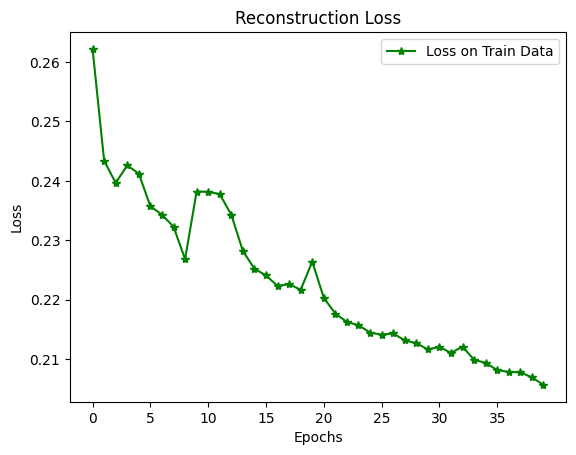

In [18]:
plt.title("Reconstruction Loss")
epochs=len(history.history['loss'])
plt.plot(np.arange(0,epochs),history.history['loss'],label="Loss on Train Data", marker='*',color='green')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,epochs,5),np.arange(0,epochs,5))
plt.legend()
plt.show()